# Computer Vision Homework 3: Big vs Small Models

## Brief

Due date: Nov 13, 2023

Required files: `homework-3.ipynb`, `report.pdf`

To download the jupyter notebook from colab, you can refer to the colab tutorial we gave.


## Codes for Problem 1 and Problem 2

### Import Packages

In [ ]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import transforms, models, datasets
from tqdm import tqdm

%matplotlib inline

In [ ]:
from torch.utils.tensorboard import SummaryWriter
os.system('rm -r runs')
print('removing previos run dir')
writer = SummaryWriter()

removing previos run dir


### Check GPU Environment

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4ea6adc4-5613-e2ec-1d52-6fddf65e571d)


### Set the Seed to Reproduce the Result

In [ ]:
def set_all_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_all_seed(123)

### Create Dataset and Dataloader

In [ ]:
batch_size = 256

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

sixteenth_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//16)
half_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//2)

sixteenth_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sixteenth_train_sampler)
half_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=half_train_sampler)

100%|██████████| 170498071/170498071 [00:13<00:00, 12542462.29it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Load Models

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.
model.fc = nn.Linear(model.fc.in_features, out_features=10, bias=True)
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


### Training and Testing Models

In [ ]:
# TODO: Fill in the code cell according to the pytorch tutorial we gave.
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.train()

    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 200

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/test', test_acc, epoch)

writer.close()

100%|██████████| 40/40 [00:03<00:00, 12.46it/s]


Epoch  1: Loss = 1.5600 Acc = 0.43 Test_Loss = 1.4305 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 12.91it/s]


Epoch  2: Loss = 1.2028 Acc = 0.57 Test_Loss = 1.1948 Test_Acc = 0.59


100%|██████████| 40/40 [00:02<00:00, 13.44it/s]


Epoch  3: Loss = 1.0420 Acc = 0.63 Test_Loss = 1.2846 Test_Acc = 0.56


100%|██████████| 40/40 [00:03<00:00, 12.83it/s]


Epoch  4: Loss = 0.9399 Acc = 0.67 Test_Loss = 1.1252 Test_Acc = 0.62


100%|██████████| 40/40 [00:03<00:00, 13.12it/s]


Epoch  5: Loss = 0.8593 Acc = 0.70 Test_Loss = 0.8430 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 12.80it/s]


Epoch  6: Loss = 0.8003 Acc = 0.72 Test_Loss = 0.8272 Test_Acc = 0.71


100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch  7: Loss = 0.7523 Acc = 0.74 Test_Loss = 0.7634 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 12.47it/s]


Epoch  8: Loss = 0.7143 Acc = 0.75 Test_Loss = 0.7694 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 13.32it/s]


Epoch  9: Loss = 0.6786 Acc = 0.76 Test_Loss = 0.6587 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 12.98it/s]


Epoch 10: Loss = 0.6427 Acc = 0.77 Test_Loss = 0.6608 Test_Acc = 0.77


100%|██████████| 40/40 [00:02<00:00, 13.59it/s]


Epoch 11: Loss = 0.6179 Acc = 0.78 Test_Loss = 0.6904 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 13.18it/s]


Epoch 12: Loss = 0.5907 Acc = 0.79 Test_Loss = 0.6378 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 12.03it/s]


Epoch 13: Loss = 0.5709 Acc = 0.80 Test_Loss = 0.6573 Test_Acc = 0.78


100%|██████████| 40/40 [00:02<00:00, 13.63it/s]


Epoch 14: Loss = 0.5473 Acc = 0.81 Test_Loss = 0.6074 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 13.21it/s]


Epoch 15: Loss = 0.5325 Acc = 0.81 Test_Loss = 0.6199 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 13.19it/s]


Epoch 16: Loss = 0.5143 Acc = 0.82 Test_Loss = 0.5960 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


Epoch 17: Loss = 0.4988 Acc = 0.83 Test_Loss = 0.6224 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 13.32it/s]


Epoch 18: Loss = 0.4844 Acc = 0.83 Test_Loss = 0.5901 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


Epoch 19: Loss = 0.4830 Acc = 0.83 Test_Loss = 0.5830 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 13.22it/s]


Epoch 20: Loss = 0.4585 Acc = 0.84 Test_Loss = 0.5839 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.57it/s]


Epoch 21: Loss = 0.4409 Acc = 0.84 Test_Loss = 0.5992 Test_Acc = 0.80


100%|██████████| 40/40 [00:02<00:00, 13.34it/s]


Epoch 22: Loss = 0.4349 Acc = 0.85 Test_Loss = 0.5761 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


Epoch 23: Loss = 0.4254 Acc = 0.85 Test_Loss = 0.6014 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 13.31it/s]


Epoch 24: Loss = 0.4133 Acc = 0.86 Test_Loss = 0.5531 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.91it/s]


Epoch 25: Loss = 0.4003 Acc = 0.86 Test_Loss = 0.5591 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.65it/s]


Epoch 26: Loss = 0.3930 Acc = 0.86 Test_Loss = 0.5721 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 13.10it/s]


Epoch 27: Loss = 0.3844 Acc = 0.86 Test_Loss = 0.5908 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 13.46it/s]


Epoch 28: Loss = 0.3768 Acc = 0.87 Test_Loss = 0.5542 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 14.16it/s]


Epoch 29: Loss = 0.3655 Acc = 0.87 Test_Loss = 0.5581 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 30: Loss = 0.3538 Acc = 0.88 Test_Loss = 0.5442 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.41it/s]


Epoch 31: Loss = 0.3427 Acc = 0.88 Test_Loss = 0.5392 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.41it/s]


Epoch 32: Loss = 0.3405 Acc = 0.88 Test_Loss = 0.5403 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.95it/s]


Epoch 33: Loss = 0.3296 Acc = 0.88 Test_Loss = 0.5475 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.43it/s]


Epoch 34: Loss = 0.3190 Acc = 0.89 Test_Loss = 0.5377 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 14.03it/s]


Epoch 35: Loss = 0.3102 Acc = 0.89 Test_Loss = 0.5295 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.66it/s]


Epoch 36: Loss = 0.3123 Acc = 0.89 Test_Loss = 0.5421 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.98it/s]


Epoch 37: Loss = 0.2975 Acc = 0.89 Test_Loss = 0.5400 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 13.29it/s]


Epoch 38: Loss = 0.2923 Acc = 0.90 Test_Loss = 0.5609 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.96it/s]


Epoch 39: Loss = 0.2816 Acc = 0.90 Test_Loss = 0.6076 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.44it/s]


Epoch 40: Loss = 0.2796 Acc = 0.90 Test_Loss = 0.5699 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


Epoch 41: Loss = 0.2750 Acc = 0.90 Test_Loss = 0.5684 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.71it/s]


Epoch 42: Loss = 0.2601 Acc = 0.91 Test_Loss = 0.5765 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


Epoch 43: Loss = 0.2550 Acc = 0.91 Test_Loss = 0.5754 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.33it/s]


Epoch 44: Loss = 0.2592 Acc = 0.91 Test_Loss = 0.5686 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.90it/s]


Epoch 45: Loss = 0.2513 Acc = 0.91 Test_Loss = 0.5674 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 46: Loss = 0.2427 Acc = 0.91 Test_Loss = 0.5790 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 47: Loss = 0.2389 Acc = 0.91 Test_Loss = 0.5690 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.32it/s]


Epoch 48: Loss = 0.2295 Acc = 0.92 Test_Loss = 0.6056 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 14.28it/s]


Epoch 49: Loss = 0.2276 Acc = 0.92 Test_Loss = 0.6251 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Epoch 50: Loss = 0.2178 Acc = 0.92 Test_Loss = 0.5712 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.39it/s]


Epoch 51: Loss = 0.2210 Acc = 0.92 Test_Loss = 0.6305 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 52: Loss = 0.2189 Acc = 0.92 Test_Loss = 0.6119 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.98it/s]


Epoch 53: Loss = 0.2076 Acc = 0.93 Test_Loss = 0.5801 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.49it/s]


Epoch 54: Loss = 0.2046 Acc = 0.93 Test_Loss = 0.5783 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


Epoch 55: Loss = 0.1936 Acc = 0.93 Test_Loss = 0.6050 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 56: Loss = 0.1948 Acc = 0.93 Test_Loss = 0.6167 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


Epoch 57: Loss = 0.1945 Acc = 0.93 Test_Loss = 0.6004 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.43it/s]


Epoch 58: Loss = 0.1902 Acc = 0.93 Test_Loss = 0.6281 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.60it/s]


Epoch 59: Loss = 0.1879 Acc = 0.93 Test_Loss = 0.6468 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 13.26it/s]


Epoch 60: Loss = 0.1861 Acc = 0.93 Test_Loss = 0.6472 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 61: Loss = 0.1778 Acc = 0.94 Test_Loss = 0.6084 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.13it/s]


Epoch 62: Loss = 0.1822 Acc = 0.93 Test_Loss = 0.6431 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.92it/s]


Epoch 63: Loss = 0.1679 Acc = 0.94 Test_Loss = 0.6531 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.22it/s]


Epoch 64: Loss = 0.1707 Acc = 0.94 Test_Loss = 0.6391 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 65: Loss = 0.1625 Acc = 0.94 Test_Loss = 0.6438 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.47it/s]


Epoch 66: Loss = 0.1655 Acc = 0.94 Test_Loss = 0.6748 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.86it/s]


Epoch 67: Loss = 0.1628 Acc = 0.94 Test_Loss = 0.6249 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.49it/s]


Epoch 68: Loss = 0.1569 Acc = 0.94 Test_Loss = 0.6319 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.72it/s]


Epoch 69: Loss = 0.1567 Acc = 0.94 Test_Loss = 0.6490 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.45it/s]


Epoch 70: Loss = 0.1482 Acc = 0.95 Test_Loss = 0.6674 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.23it/s]


Epoch 71: Loss = 0.1466 Acc = 0.95 Test_Loss = 0.6384 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.14it/s]


Epoch 72: Loss = 0.1469 Acc = 0.95 Test_Loss = 0.6447 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.97it/s]


Epoch 73: Loss = 0.1414 Acc = 0.95 Test_Loss = 0.6863 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.76it/s]


Epoch 74: Loss = 0.1371 Acc = 0.95 Test_Loss = 0.6608 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.68it/s]


Epoch 75: Loss = 0.1371 Acc = 0.95 Test_Loss = 0.7549 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.99it/s]


Epoch 76: Loss = 0.1344 Acc = 0.95 Test_Loss = 0.6767 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.98it/s]


Epoch 77: Loss = 0.1376 Acc = 0.95 Test_Loss = 0.6896 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.24it/s]


Epoch 78: Loss = 0.1349 Acc = 0.95 Test_Loss = 0.6692 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.68it/s]


Epoch 79: Loss = 0.1296 Acc = 0.95 Test_Loss = 0.6797 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.55it/s]


Epoch 80: Loss = 0.1273 Acc = 0.95 Test_Loss = 0.6531 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.81it/s]


Epoch 81: Loss = 0.1282 Acc = 0.95 Test_Loss = 0.6764 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.40it/s]


Epoch 82: Loss = 0.1277 Acc = 0.96 Test_Loss = 0.6661 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 83: Loss = 0.1216 Acc = 0.96 Test_Loss = 0.6744 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.97it/s]


Epoch 84: Loss = 0.1192 Acc = 0.96 Test_Loss = 0.7009 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


Epoch 85: Loss = 0.1186 Acc = 0.96 Test_Loss = 0.7115 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.59it/s]


Epoch 86: Loss = 0.1235 Acc = 0.96 Test_Loss = 0.7022 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.56it/s]


Epoch 87: Loss = 0.1172 Acc = 0.96 Test_Loss = 0.7004 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.95it/s]


Epoch 88: Loss = 0.1158 Acc = 0.96 Test_Loss = 0.7133 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.25it/s]


Epoch 89: Loss = 0.1165 Acc = 0.96 Test_Loss = 0.6901 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.40it/s]


Epoch 90: Loss = 0.1095 Acc = 0.96 Test_Loss = 0.7217 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.00it/s]


Epoch 91: Loss = 0.1113 Acc = 0.96 Test_Loss = 0.7091 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 92: Loss = 0.1126 Acc = 0.96 Test_Loss = 0.6997 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 93: Loss = 0.1053 Acc = 0.96 Test_Loss = 0.6948 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.28it/s]


Epoch 94: Loss = 0.1051 Acc = 0.96 Test_Loss = 0.7221 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.45it/s]


Epoch 95: Loss = 0.1058 Acc = 0.96 Test_Loss = 0.7440 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.12it/s]


Epoch 96: Loss = 0.1024 Acc = 0.96 Test_Loss = 0.7102 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.12it/s]


Epoch 97: Loss = 0.1031 Acc = 0.96 Test_Loss = 0.7349 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.41it/s]


Epoch 98: Loss = 0.1022 Acc = 0.96 Test_Loss = 0.7241 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.10it/s]


Epoch 99: Loss = 0.1006 Acc = 0.96 Test_Loss = 0.7258 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.85it/s]


Epoch 100: Loss = 0.0986 Acc = 0.97 Test_Loss = 0.6879 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.42it/s]


Epoch 101: Loss = 0.0968 Acc = 0.97 Test_Loss = 0.7362 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 102: Loss = 0.1020 Acc = 0.96 Test_Loss = 0.7383 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.30it/s]


Epoch 103: Loss = 0.0920 Acc = 0.97 Test_Loss = 0.7597 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.21it/s]


Epoch 104: Loss = 0.0931 Acc = 0.97 Test_Loss = 0.7835 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.25it/s]


Epoch 105: Loss = 0.0911 Acc = 0.97 Test_Loss = 0.7953 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.72it/s]


Epoch 106: Loss = 0.0915 Acc = 0.97 Test_Loss = 0.7486 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.66it/s]


Epoch 107: Loss = 0.0878 Acc = 0.97 Test_Loss = 0.7113 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Epoch 108: Loss = 0.0947 Acc = 0.97 Test_Loss = 0.7668 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.18it/s]


Epoch 109: Loss = 0.0920 Acc = 0.97 Test_Loss = 0.7376 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 14.07it/s]


Epoch 110: Loss = 0.0869 Acc = 0.97 Test_Loss = 0.7410 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.83it/s]


Epoch 111: Loss = 0.0831 Acc = 0.97 Test_Loss = 0.7603 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.47it/s]


Epoch 112: Loss = 0.0887 Acc = 0.97 Test_Loss = 0.7699 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.31it/s]


Epoch 113: Loss = 0.0857 Acc = 0.97 Test_Loss = 0.7665 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Epoch 114: Loss = 0.0915 Acc = 0.97 Test_Loss = 0.7469 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.20it/s]


Epoch 115: Loss = 0.0856 Acc = 0.97 Test_Loss = 0.7767 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.88it/s]


Epoch 116: Loss = 0.0871 Acc = 0.97 Test_Loss = 0.7893 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


Epoch 117: Loss = 0.0790 Acc = 0.97 Test_Loss = 0.7534 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.35it/s]


Epoch 118: Loss = 0.0795 Acc = 0.97 Test_Loss = 0.8144 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.61it/s]


Epoch 119: Loss = 0.0819 Acc = 0.97 Test_Loss = 0.7743 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.37it/s]


Epoch 120: Loss = 0.0877 Acc = 0.97 Test_Loss = 0.7513 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.81it/s]


Epoch 121: Loss = 0.0783 Acc = 0.97 Test_Loss = 0.7496 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.54it/s]


Epoch 122: Loss = 0.0818 Acc = 0.97 Test_Loss = 0.7575 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.85it/s]


Epoch 123: Loss = 0.0745 Acc = 0.97 Test_Loss = 0.8019 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 124: Loss = 0.0778 Acc = 0.97 Test_Loss = 0.7788 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.54it/s]


Epoch 125: Loss = 0.0798 Acc = 0.97 Test_Loss = 0.7421 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.09it/s]


Epoch 126: Loss = 0.0792 Acc = 0.97 Test_Loss = 0.7655 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


Epoch 127: Loss = 0.0757 Acc = 0.97 Test_Loss = 0.7652 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.52it/s]


Epoch 128: Loss = 0.0772 Acc = 0.97 Test_Loss = 0.7743 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.68it/s]


Epoch 129: Loss = 0.0704 Acc = 0.98 Test_Loss = 0.7699 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.14it/s]


Epoch 130: Loss = 0.0697 Acc = 0.98 Test_Loss = 0.8509 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.80it/s]


Epoch 131: Loss = 0.0766 Acc = 0.97 Test_Loss = 0.7527 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.92it/s]


Epoch 132: Loss = 0.0711 Acc = 0.97 Test_Loss = 0.8176 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.96it/s]


Epoch 133: Loss = 0.0749 Acc = 0.97 Test_Loss = 0.7474 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.49it/s]


Epoch 134: Loss = 0.0745 Acc = 0.97 Test_Loss = 0.7960 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.41it/s]


Epoch 135: Loss = 0.0731 Acc = 0.97 Test_Loss = 0.7725 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 136: Loss = 0.0696 Acc = 0.97 Test_Loss = 0.7676 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 137: Loss = 0.0734 Acc = 0.97 Test_Loss = 0.7670 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.60it/s]


Epoch 138: Loss = 0.0693 Acc = 0.98 Test_Loss = 0.7959 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.04it/s]


Epoch 139: Loss = 0.0739 Acc = 0.97 Test_Loss = 0.7777 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


Epoch 140: Loss = 0.0690 Acc = 0.98 Test_Loss = 0.7981 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.62it/s]


Epoch 141: Loss = 0.0631 Acc = 0.98 Test_Loss = 0.8057 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.58it/s]


Epoch 142: Loss = 0.0658 Acc = 0.98 Test_Loss = 0.7948 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.66it/s]


Epoch 143: Loss = 0.0663 Acc = 0.98 Test_Loss = 0.7722 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  9.57it/s]


Epoch 144: Loss = 0.0659 Acc = 0.98 Test_Loss = 0.8262 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.15it/s]


Epoch 145: Loss = 0.0668 Acc = 0.98 Test_Loss = 0.8156 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.34it/s]


Epoch 146: Loss = 0.0682 Acc = 0.98 Test_Loss = 0.8109 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.42it/s]


Epoch 147: Loss = 0.0655 Acc = 0.98 Test_Loss = 0.8161 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.70it/s]


Epoch 148: Loss = 0.0647 Acc = 0.98 Test_Loss = 0.7796 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 149: Loss = 0.0653 Acc = 0.98 Test_Loss = 0.7718 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.09it/s]


Epoch 150: Loss = 0.0623 Acc = 0.98 Test_Loss = 0.8051 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.09it/s]


Epoch 151: Loss = 0.0577 Acc = 0.98 Test_Loss = 0.8156 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.56it/s]


Epoch 152: Loss = 0.0631 Acc = 0.98 Test_Loss = 0.8179 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 153: Loss = 0.0658 Acc = 0.98 Test_Loss = 0.8373 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 154: Loss = 0.0637 Acc = 0.98 Test_Loss = 0.7987 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.15it/s]


Epoch 155: Loss = 0.0661 Acc = 0.98 Test_Loss = 0.8125 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.21it/s]


Epoch 156: Loss = 0.0571 Acc = 0.98 Test_Loss = 0.8152 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.89it/s]


Epoch 157: Loss = 0.0621 Acc = 0.98 Test_Loss = 0.8037 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.73it/s]


Epoch 158: Loss = 0.0629 Acc = 0.98 Test_Loss = 0.8002 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.51it/s]


Epoch 159: Loss = 0.0587 Acc = 0.98 Test_Loss = 0.7778 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.15it/s]


Epoch 160: Loss = 0.0556 Acc = 0.98 Test_Loss = 0.8128 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.64it/s]


Epoch 161: Loss = 0.0619 Acc = 0.98 Test_Loss = 0.8212 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.97it/s]


Epoch 162: Loss = 0.0571 Acc = 0.98 Test_Loss = 0.7981 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.17it/s]


Epoch 163: Loss = 0.0554 Acc = 0.98 Test_Loss = 0.8185 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.87it/s]


Epoch 164: Loss = 0.0599 Acc = 0.98 Test_Loss = 0.8070 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  9.75it/s]


Epoch 165: Loss = 0.0575 Acc = 0.98 Test_Loss = 0.8052 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.57it/s]


Epoch 166: Loss = 0.0579 Acc = 0.98 Test_Loss = 0.8035 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.49it/s]


Epoch 167: Loss = 0.0587 Acc = 0.98 Test_Loss = 0.8261 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.99it/s]


Epoch 168: Loss = 0.0524 Acc = 0.98 Test_Loss = 0.8297 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  9.67it/s]


Epoch 169: Loss = 0.0628 Acc = 0.98 Test_Loss = 0.7744 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.49it/s]


Epoch 170: Loss = 0.0570 Acc = 0.98 Test_Loss = 0.7824 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.30it/s]


Epoch 171: Loss = 0.0502 Acc = 0.98 Test_Loss = 0.8229 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.34it/s]


Epoch 172: Loss = 0.0574 Acc = 0.98 Test_Loss = 0.8401 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  9.91it/s]


Epoch 173: Loss = 0.0577 Acc = 0.98 Test_Loss = 0.7822 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.33it/s]


Epoch 174: Loss = 0.0531 Acc = 0.98 Test_Loss = 0.8410 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


Epoch 175: Loss = 0.0502 Acc = 0.98 Test_Loss = 0.8583 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.23it/s]


Epoch 176: Loss = 0.0574 Acc = 0.98 Test_Loss = 0.8361 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.11it/s]


Epoch 177: Loss = 0.0586 Acc = 0.98 Test_Loss = 0.8141 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.45it/s]


Epoch 178: Loss = 0.0521 Acc = 0.98 Test_Loss = 0.8237 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  9.65it/s]


Epoch 179: Loss = 0.0479 Acc = 0.98 Test_Loss = 0.8285 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.08it/s]


Epoch 180: Loss = 0.0552 Acc = 0.98 Test_Loss = 0.8578 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


Epoch 181: Loss = 0.0558 Acc = 0.98 Test_Loss = 0.8311 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 182: Loss = 0.0556 Acc = 0.98 Test_Loss = 0.8397 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.83it/s]


Epoch 183: Loss = 0.0531 Acc = 0.98 Test_Loss = 0.8191 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.01it/s]


Epoch 184: Loss = 0.0527 Acc = 0.98 Test_Loss = 0.8496 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.45it/s]


Epoch 185: Loss = 0.0508 Acc = 0.98 Test_Loss = 0.8524 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


Epoch 186: Loss = 0.0490 Acc = 0.98 Test_Loss = 0.8656 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.90it/s]


Epoch 187: Loss = 0.0521 Acc = 0.98 Test_Loss = 0.8489 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.26it/s]


Epoch 188: Loss = 0.0517 Acc = 0.98 Test_Loss = 0.8256 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.27it/s]


Epoch 189: Loss = 0.0574 Acc = 0.98 Test_Loss = 0.8448 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


Epoch 190: Loss = 0.0496 Acc = 0.98 Test_Loss = 0.8294 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 191: Loss = 0.0530 Acc = 0.98 Test_Loss = 0.8893 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Epoch 192: Loss = 0.0519 Acc = 0.98 Test_Loss = 0.8535 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.59it/s]


Epoch 193: Loss = 0.0501 Acc = 0.98 Test_Loss = 0.8218 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.43it/s]


Epoch 194: Loss = 0.0495 Acc = 0.98 Test_Loss = 0.8878 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.21it/s]


Epoch 195: Loss = 0.0486 Acc = 0.98 Test_Loss = 0.8384 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.37it/s]


Epoch 196: Loss = 0.0468 Acc = 0.98 Test_Loss = 0.8495 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.44it/s]


Epoch 197: Loss = 0.0495 Acc = 0.98 Test_Loss = 0.8214 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.15it/s]


Epoch 198: Loss = 0.0455 Acc = 0.98 Test_Loss = 0.8561 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.56it/s]


Epoch 199: Loss = 0.0472 Acc = 0.98 Test_Loss = 0.8529 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.39it/s]

Epoch 200: Loss = 0.0470 Acc = 0.98 Test_Loss = 0.8399 Test_Acc = 0.85


In [ ]:
print(best_acc)

0.8513


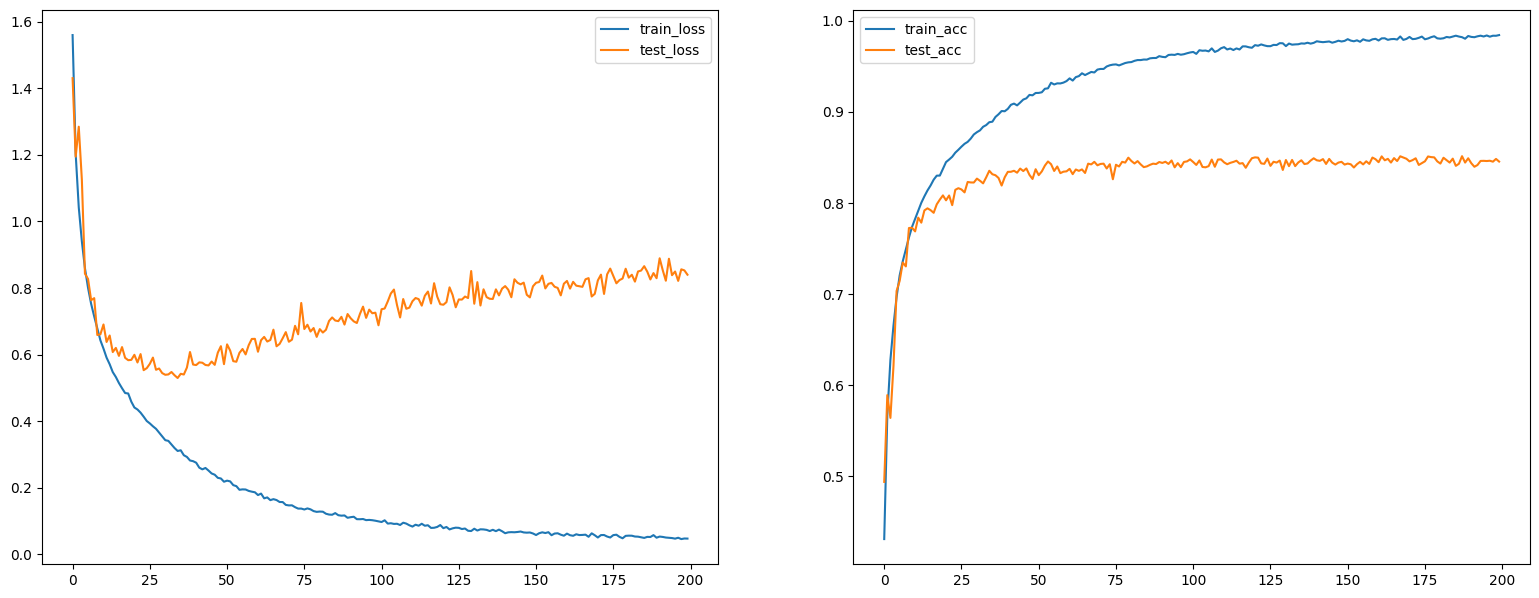

In [ ]:
plt.figure(figsize=(19.2,7.2))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.legend()

plt.show()

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights="IMAGENET1K_V1")

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.
model.fc = nn.Linear(model.fc.in_features, out_features=10, bias=True)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 200

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/test', test_acc, epoch)

writer.close()

100%|██████████| 40/40 [00:02<00:00, 14.14it/s]


Epoch  1: Loss = 1.0092 Acc = 0.65 Test_Loss = 0.7359 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 11.66it/s]


Epoch  2: Loss = 0.6943 Acc = 0.76 Test_Loss = 0.6915 Test_Acc = 0.76


100%|██████████| 40/40 [00:02<00:00, 13.54it/s]


Epoch  3: Loss = 0.6066 Acc = 0.79 Test_Loss = 0.6725 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 10.62it/s]


Epoch  4: Loss = 0.5496 Acc = 0.81 Test_Loss = 0.6051 Test_Acc = 0.80


100%|██████████| 40/40 [00:02<00:00, 13.68it/s]


Epoch  5: Loss = 0.5172 Acc = 0.82 Test_Loss = 0.5556 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.11it/s]


Epoch  6: Loss = 0.4781 Acc = 0.84 Test_Loss = 0.5392 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]


Epoch  7: Loss = 0.4573 Acc = 0.84 Test_Loss = 0.5138 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch  8: Loss = 0.4339 Acc = 0.85 Test_Loss = 0.5060 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.60it/s]


Epoch  9: Loss = 0.4165 Acc = 0.86 Test_Loss = 0.5361 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 12.28it/s]


Epoch 10: Loss = 0.4026 Acc = 0.86 Test_Loss = 0.5383 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.60it/s]


Epoch 11: Loss = 0.3833 Acc = 0.87 Test_Loss = 0.4906 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.04it/s]


Epoch 12: Loss = 0.3657 Acc = 0.87 Test_Loss = 0.4744 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.61it/s]


Epoch 13: Loss = 0.3619 Acc = 0.87 Test_Loss = 0.5117 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.66it/s]


Epoch 14: Loss = 0.3416 Acc = 0.88 Test_Loss = 0.4754 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.45it/s]


Epoch 15: Loss = 0.3312 Acc = 0.89 Test_Loss = 0.5046 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.33it/s]


Epoch 16: Loss = 0.3211 Acc = 0.89 Test_Loss = 0.4567 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.66it/s]


Epoch 17: Loss = 0.3088 Acc = 0.89 Test_Loss = 0.4646 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 14.02it/s]


Epoch 18: Loss = 0.3074 Acc = 0.89 Test_Loss = 0.4733 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 19: Loss = 0.2889 Acc = 0.90 Test_Loss = 0.4795 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.41it/s]


Epoch 20: Loss = 0.2866 Acc = 0.90 Test_Loss = 0.4848 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.85it/s]


Epoch 21: Loss = 0.2771 Acc = 0.90 Test_Loss = 0.5062 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.47it/s]


Epoch 22: Loss = 0.2690 Acc = 0.91 Test_Loss = 0.4776 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.91it/s]


Epoch 23: Loss = 0.2871 Acc = 0.90 Test_Loss = 0.4733 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.63it/s]


Epoch 24: Loss = 0.2576 Acc = 0.91 Test_Loss = 0.4652 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.23it/s]


Epoch 25: Loss = 0.2439 Acc = 0.92 Test_Loss = 0.4772 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.98it/s]


Epoch 26: Loss = 0.2383 Acc = 0.92 Test_Loss = 0.4806 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.42it/s]


Epoch 27: Loss = 0.2301 Acc = 0.92 Test_Loss = 0.4647 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.44it/s]


Epoch 28: Loss = 0.2272 Acc = 0.92 Test_Loss = 0.4546 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.98it/s]


Epoch 29: Loss = 0.2214 Acc = 0.92 Test_Loss = 0.4617 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.30it/s]


Epoch 30: Loss = 0.2145 Acc = 0.92 Test_Loss = 0.4639 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.21it/s]


Epoch 31: Loss = 0.2120 Acc = 0.93 Test_Loss = 0.4596 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


Epoch 32: Loss = 0.2058 Acc = 0.93 Test_Loss = 0.4887 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.71it/s]


Epoch 33: Loss = 0.2014 Acc = 0.93 Test_Loss = 0.4837 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.20it/s]


Epoch 34: Loss = 0.1918 Acc = 0.93 Test_Loss = 0.5010 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.10it/s]


Epoch 35: Loss = 0.1870 Acc = 0.94 Test_Loss = 0.4835 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.06it/s]


Epoch 36: Loss = 0.1897 Acc = 0.93 Test_Loss = 0.5335 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 37: Loss = 0.1912 Acc = 0.93 Test_Loss = 0.4794 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.63it/s]


Epoch 38: Loss = 0.1768 Acc = 0.94 Test_Loss = 0.5113 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 39: Loss = 0.1704 Acc = 0.94 Test_Loss = 0.5653 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.85it/s]


Epoch 40: Loss = 0.1669 Acc = 0.94 Test_Loss = 0.4877 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.78it/s]


Epoch 41: Loss = 0.1646 Acc = 0.94 Test_Loss = 0.4861 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.03it/s]


Epoch 42: Loss = 0.1590 Acc = 0.94 Test_Loss = 0.5062 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


Epoch 43: Loss = 0.1558 Acc = 0.95 Test_Loss = 0.4967 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.51it/s]


Epoch 44: Loss = 0.1492 Acc = 0.95 Test_Loss = 0.4943 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 45: Loss = 0.1504 Acc = 0.95 Test_Loss = 0.5059 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.57it/s]


Epoch 46: Loss = 0.1424 Acc = 0.95 Test_Loss = 0.5323 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.96it/s]


Epoch 47: Loss = 0.1645 Acc = 0.94 Test_Loss = 0.4968 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.45it/s]


Epoch 48: Loss = 0.1457 Acc = 0.95 Test_Loss = 0.5063 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.91it/s]


Epoch 49: Loss = 0.1405 Acc = 0.95 Test_Loss = 0.5155 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.63it/s]


Epoch 50: Loss = 0.1388 Acc = 0.95 Test_Loss = 0.5501 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.42it/s]


Epoch 51: Loss = 0.1329 Acc = 0.95 Test_Loss = 0.5265 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.86it/s]


Epoch 52: Loss = 0.1309 Acc = 0.95 Test_Loss = 0.5272 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.57it/s]


Epoch 53: Loss = 0.1278 Acc = 0.96 Test_Loss = 0.4995 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.57it/s]


Epoch 54: Loss = 0.1234 Acc = 0.96 Test_Loss = 0.5200 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.94it/s]


Epoch 55: Loss = 0.1237 Acc = 0.96 Test_Loss = 0.5208 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.79it/s]


Epoch 56: Loss = 0.1217 Acc = 0.96 Test_Loss = 0.5206 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Epoch 57: Loss = 0.1149 Acc = 0.96 Test_Loss = 0.5518 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


Epoch 58: Loss = 0.1484 Acc = 0.95 Test_Loss = 0.5064 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.00it/s]


Epoch 59: Loss = 0.1127 Acc = 0.96 Test_Loss = 0.5302 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 60: Loss = 0.1122 Acc = 0.96 Test_Loss = 0.5375 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.85it/s]


Epoch 61: Loss = 0.1109 Acc = 0.96 Test_Loss = 0.5468 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.49it/s]


Epoch 62: Loss = 0.1073 Acc = 0.96 Test_Loss = 0.5160 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.64it/s]


Epoch 63: Loss = 0.1158 Acc = 0.96 Test_Loss = 0.5277 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.49it/s]


Epoch 64: Loss = 0.1049 Acc = 0.96 Test_Loss = 0.5267 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.59it/s]


Epoch 65: Loss = 0.1135 Acc = 0.96 Test_Loss = 0.5357 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.03it/s]


Epoch 66: Loss = 0.1100 Acc = 0.96 Test_Loss = 0.5434 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.59it/s]


Epoch 67: Loss = 0.1014 Acc = 0.96 Test_Loss = 0.6933 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.55it/s]


Epoch 68: Loss = 0.1783 Acc = 0.94 Test_Loss = 0.5311 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.35it/s]


Epoch 69: Loss = 0.1046 Acc = 0.96 Test_Loss = 0.5267 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.61it/s]


Epoch 70: Loss = 0.0988 Acc = 0.97 Test_Loss = 0.5399 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 71: Loss = 0.0989 Acc = 0.97 Test_Loss = 0.5932 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.24it/s]


Epoch 72: Loss = 0.0927 Acc = 0.97 Test_Loss = 0.5671 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.17it/s]


Epoch 73: Loss = 0.0916 Acc = 0.97 Test_Loss = 0.5903 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Epoch 74: Loss = 0.0915 Acc = 0.97 Test_Loss = 0.5724 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.03it/s]


Epoch 75: Loss = 0.0902 Acc = 0.97 Test_Loss = 0.5333 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 13.11it/s]


Epoch 76: Loss = 0.0842 Acc = 0.97 Test_Loss = 0.5716 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


Epoch 77: Loss = 0.0930 Acc = 0.97 Test_Loss = 0.5839 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.89it/s]


Epoch 78: Loss = 0.0853 Acc = 0.97 Test_Loss = 0.5601 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.35it/s]


Epoch 79: Loss = 0.0887 Acc = 0.97 Test_Loss = 0.5557 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 12.99it/s]


Epoch 80: Loss = 0.0863 Acc = 0.97 Test_Loss = 0.6086 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.62it/s]


Epoch 81: Loss = 0.0876 Acc = 0.97 Test_Loss = 0.5551 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 14.05it/s]


Epoch 82: Loss = 0.0870 Acc = 0.97 Test_Loss = 0.6227 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.21it/s]


Epoch 83: Loss = 0.0837 Acc = 0.97 Test_Loss = 0.5892 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.22it/s]


Epoch 84: Loss = 0.0824 Acc = 0.97 Test_Loss = 0.5936 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.21it/s]


Epoch 85: Loss = 0.0777 Acc = 0.97 Test_Loss = 0.5870 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 86: Loss = 0.0826 Acc = 0.97 Test_Loss = 0.5631 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.89it/s]


Epoch 87: Loss = 0.0811 Acc = 0.97 Test_Loss = 0.6021 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.09it/s]


Epoch 88: Loss = 0.0815 Acc = 0.97 Test_Loss = 0.5749 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.91it/s]


Epoch 89: Loss = 0.0782 Acc = 0.97 Test_Loss = 0.6119 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.29it/s]


Epoch 90: Loss = 0.0834 Acc = 0.97 Test_Loss = 1.6620 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 12.38it/s]


Epoch 91: Loss = 0.0964 Acc = 0.97 Test_Loss = 0.5598 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 13.29it/s]


Epoch 92: Loss = 0.0774 Acc = 0.97 Test_Loss = 0.5937 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.20it/s]


Epoch 93: Loss = 0.0781 Acc = 0.97 Test_Loss = 0.5853 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.49it/s]


Epoch 94: Loss = 0.0764 Acc = 0.97 Test_Loss = 0.5947 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 95: Loss = 0.0716 Acc = 0.97 Test_Loss = 0.5995 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 96: Loss = 0.0692 Acc = 0.98 Test_Loss = 0.6173 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.06it/s]


Epoch 97: Loss = 0.0730 Acc = 0.97 Test_Loss = 0.5931 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.76it/s]


Epoch 98: Loss = 0.0706 Acc = 0.97 Test_Loss = 0.6029 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 13.11it/s]


Epoch 99: Loss = 0.0733 Acc = 0.97 Test_Loss = 0.6147 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.67it/s]


Epoch 100: Loss = 0.0704 Acc = 0.98 Test_Loss = 0.5970 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.06it/s]


Epoch 101: Loss = 0.0682 Acc = 0.98 Test_Loss = 0.6148 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.87it/s]


Epoch 102: Loss = 0.0712 Acc = 0.98 Test_Loss = 0.5912 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.66it/s]


Epoch 103: Loss = 0.0695 Acc = 0.98 Test_Loss = 0.5965 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.44it/s]


Epoch 104: Loss = 0.0660 Acc = 0.98 Test_Loss = 0.6192 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.56it/s]


Epoch 105: Loss = 0.0701 Acc = 0.98 Test_Loss = 0.6202 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.14it/s]


Epoch 106: Loss = 0.0644 Acc = 0.98 Test_Loss = 0.6264 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.56it/s]


Epoch 107: Loss = 0.0695 Acc = 0.97 Test_Loss = 0.6316 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.62it/s]


Epoch 108: Loss = 0.0674 Acc = 0.98 Test_Loss = 0.5976 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 12.12it/s]


Epoch 109: Loss = 0.0639 Acc = 0.98 Test_Loss = 0.6309 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.96it/s]


Epoch 110: Loss = 0.0661 Acc = 0.98 Test_Loss = 0.6340 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.14it/s]


Epoch 111: Loss = 0.0661 Acc = 0.98 Test_Loss = 0.6193 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 14.15it/s]


Epoch 112: Loss = 0.0616 Acc = 0.98 Test_Loss = 0.6178 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.87it/s]


Epoch 113: Loss = 0.0649 Acc = 0.98 Test_Loss = 0.6258 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 114: Loss = 0.0625 Acc = 0.98 Test_Loss = 0.6323 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.52it/s]


Epoch 115: Loss = 0.0656 Acc = 0.98 Test_Loss = 0.6189 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.29it/s]


Epoch 116: Loss = 0.0601 Acc = 0.98 Test_Loss = 0.6320 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


Epoch 117: Loss = 0.0642 Acc = 0.98 Test_Loss = 0.6538 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.10it/s]


Epoch 118: Loss = 0.0627 Acc = 0.98 Test_Loss = 0.6230 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.14it/s]


Epoch 119: Loss = 0.0611 Acc = 0.98 Test_Loss = 0.6574 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.53it/s]


Epoch 120: Loss = 0.0587 Acc = 0.98 Test_Loss = 0.6255 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.66it/s]


Epoch 121: Loss = 0.0592 Acc = 0.98 Test_Loss = 0.6201 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 12.57it/s]


Epoch 122: Loss = 0.0561 Acc = 0.98 Test_Loss = 0.6450 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.97it/s]


Epoch 123: Loss = 0.0634 Acc = 0.98 Test_Loss = 0.6308 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 12.35it/s]


Epoch 124: Loss = 0.0571 Acc = 0.98 Test_Loss = 0.6678 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.61it/s]


Epoch 125: Loss = 0.0629 Acc = 0.98 Test_Loss = 0.6342 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.35it/s]


Epoch 126: Loss = 0.0553 Acc = 0.98 Test_Loss = 0.6331 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.94it/s]


Epoch 127: Loss = 0.0614 Acc = 0.98 Test_Loss = 0.6496 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.60it/s]


Epoch 128: Loss = 0.0593 Acc = 0.98 Test_Loss = 0.6045 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 13.31it/s]


Epoch 129: Loss = 0.0526 Acc = 0.98 Test_Loss = 0.6408 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.46it/s]


Epoch 130: Loss = 0.0584 Acc = 0.98 Test_Loss = 0.6359 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 131: Loss = 0.0673 Acc = 0.98 Test_Loss = 0.6367 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.14it/s]


Epoch 132: Loss = 0.0554 Acc = 0.98 Test_Loss = 0.6400 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 133: Loss = 0.0503 Acc = 0.98 Test_Loss = 0.6557 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch 134: Loss = 0.0536 Acc = 0.98 Test_Loss = 0.6709 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 135: Loss = 0.0553 Acc = 0.98 Test_Loss = 0.7251 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.44it/s]


Epoch 136: Loss = 0.1053 Acc = 0.97 Test_Loss = 0.5752 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.39it/s]


Epoch 137: Loss = 0.0638 Acc = 0.98 Test_Loss = 0.6619 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.47it/s]


Epoch 138: Loss = 0.0545 Acc = 0.98 Test_Loss = 0.6622 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.31it/s]


Epoch 139: Loss = 0.0474 Acc = 0.98 Test_Loss = 0.6481 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 13.27it/s]


Epoch 140: Loss = 0.0489 Acc = 0.98 Test_Loss = 0.6695 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.16it/s]


Epoch 141: Loss = 0.0467 Acc = 0.98 Test_Loss = 0.6543 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 13.32it/s]


Epoch 142: Loss = 0.0514 Acc = 0.98 Test_Loss = 0.6763 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.47it/s]


Epoch 143: Loss = 0.0505 Acc = 0.98 Test_Loss = 0.6245 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 12.81it/s]


Epoch 144: Loss = 0.0484 Acc = 0.98 Test_Loss = 0.6365 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.73it/s]


Epoch 145: Loss = 0.0509 Acc = 0.98 Test_Loss = 0.6651 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.07it/s]


Epoch 146: Loss = 0.0478 Acc = 0.98 Test_Loss = 0.6570 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Epoch 147: Loss = 0.0523 Acc = 0.98 Test_Loss = 0.6861 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.09it/s]


Epoch 148: Loss = 0.0470 Acc = 0.98 Test_Loss = 0.6655 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 149: Loss = 0.0542 Acc = 0.98 Test_Loss = 0.6657 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 14.16it/s]


Epoch 150: Loss = 0.0469 Acc = 0.98 Test_Loss = 0.6749 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.98it/s]


Epoch 151: Loss = 0.0471 Acc = 0.98 Test_Loss = 0.6721 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.96it/s]


Epoch 152: Loss = 0.0492 Acc = 0.98 Test_Loss = 0.6550 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 14.06it/s]


Epoch 153: Loss = 0.0516 Acc = 0.98 Test_Loss = 0.7085 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 154: Loss = 0.0460 Acc = 0.98 Test_Loss = 0.6720 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.65it/s]


Epoch 155: Loss = 0.0506 Acc = 0.98 Test_Loss = 0.6598 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.05it/s]


Epoch 156: Loss = 0.0480 Acc = 0.98 Test_Loss = 0.6538 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 12.75it/s]


Epoch 157: Loss = 0.0469 Acc = 0.98 Test_Loss = 0.7038 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.30it/s]


Epoch 158: Loss = 0.0447 Acc = 0.98 Test_Loss = 0.6826 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.85it/s]


Epoch 159: Loss = 0.0461 Acc = 0.98 Test_Loss = 0.6905 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.65it/s]


Epoch 160: Loss = 0.0506 Acc = 0.98 Test_Loss = 0.6883 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.47it/s]


Epoch 161: Loss = 0.0499 Acc = 0.98 Test_Loss = 0.6635 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 162: Loss = 0.0459 Acc = 0.98 Test_Loss = 0.6666 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 163: Loss = 0.0453 Acc = 0.98 Test_Loss = 0.6942 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.63it/s]


Epoch 164: Loss = 0.0449 Acc = 0.98 Test_Loss = 0.6879 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.91it/s]


Epoch 165: Loss = 0.0456 Acc = 0.98 Test_Loss = 0.6845 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.71it/s]


Epoch 166: Loss = 0.0470 Acc = 0.98 Test_Loss = 0.6985 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 167: Loss = 0.0517 Acc = 0.98 Test_Loss = 0.6899 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.88it/s]


Epoch 168: Loss = 0.0431 Acc = 0.99 Test_Loss = 0.6706 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 169: Loss = 0.0456 Acc = 0.98 Test_Loss = 0.6768 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.22it/s]


Epoch 170: Loss = 0.0397 Acc = 0.99 Test_Loss = 0.6675 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 14.17it/s]


Epoch 171: Loss = 0.0394 Acc = 0.99 Test_Loss = 0.7304 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.20it/s]


Epoch 172: Loss = 0.0495 Acc = 0.98 Test_Loss = 0.6725 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Epoch 173: Loss = 0.0464 Acc = 0.98 Test_Loss = 0.6831 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.00it/s]


Epoch 174: Loss = 0.0452 Acc = 0.98 Test_Loss = 0.7010 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Epoch 175: Loss = 0.0434 Acc = 0.98 Test_Loss = 0.6981 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.34it/s]


Epoch 176: Loss = 0.0461 Acc = 0.98 Test_Loss = 0.6724 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 13.12it/s]


Epoch 177: Loss = 0.0415 Acc = 0.99 Test_Loss = 0.7116 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.45it/s]


Epoch 178: Loss = 0.0442 Acc = 0.98 Test_Loss = 0.6916 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.62it/s]


Epoch 179: Loss = 0.0552 Acc = 0.98 Test_Loss = 0.7517 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.43it/s]


Epoch 180: Loss = 0.0578 Acc = 0.98 Test_Loss = 0.6986 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.20it/s]


Epoch 181: Loss = 0.0431 Acc = 0.98 Test_Loss = 0.6826 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


Epoch 182: Loss = 0.0387 Acc = 0.99 Test_Loss = 0.7025 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.95it/s]


Epoch 183: Loss = 0.0409 Acc = 0.99 Test_Loss = 0.7225 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.59it/s]


Epoch 184: Loss = 0.0388 Acc = 0.99 Test_Loss = 0.7081 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


Epoch 185: Loss = 0.0405 Acc = 0.99 Test_Loss = 0.7202 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.74it/s]


Epoch 186: Loss = 0.0377 Acc = 0.99 Test_Loss = 0.7250 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.08it/s]


Epoch 187: Loss = 0.0427 Acc = 0.99 Test_Loss = 0.7141 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.38it/s]


Epoch 188: Loss = 0.0418 Acc = 0.99 Test_Loss = 0.6744 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 189: Loss = 0.0413 Acc = 0.99 Test_Loss = 0.6829 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 190: Loss = 0.0414 Acc = 0.99 Test_Loss = 0.6991 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.10it/s]


Epoch 191: Loss = 0.0398 Acc = 0.99 Test_Loss = 0.7265 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.77it/s]


Epoch 192: Loss = 0.0425 Acc = 0.99 Test_Loss = 4.3440 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 193: Loss = 0.0496 Acc = 0.98 Test_Loss = 0.7054 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Epoch 194: Loss = 0.0377 Acc = 0.99 Test_Loss = 0.7071 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 12.19it/s]


Epoch 195: Loss = 0.0367 Acc = 0.99 Test_Loss = 0.7242 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 196: Loss = 0.0377 Acc = 0.99 Test_Loss = 0.7122 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 197: Loss = 0.0377 Acc = 0.99 Test_Loss = 0.7208 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.26it/s]


Epoch 198: Loss = 0.0390 Acc = 0.99 Test_Loss = 0.7376 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.05it/s]


Epoch 199: Loss = 0.0399 Acc = 0.99 Test_Loss = 0.7299 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.85it/s]

Epoch 200: Loss = 0.0385 Acc = 0.99 Test_Loss = 0.7110 Test_Acc = 0.86


In [ ]:
print(best_acc)

0.8703


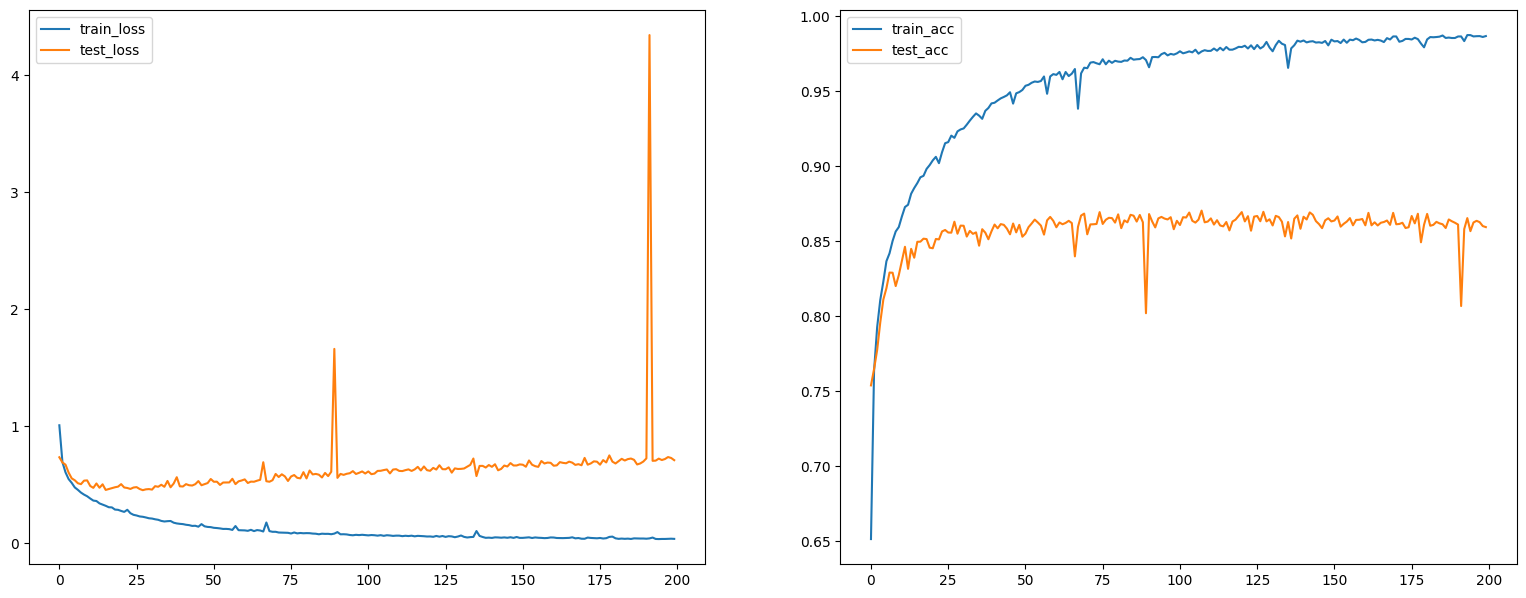

In [ ]:
plt.figure(figsize=(19.2,7.2))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.legend()

plt.show()

## Credits

1. [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)